# SECTION 1: MODEL TRAINING AND EXPORT

This section contains all the code for:
1. Data preprocessing
2. Model training
3. Feature engineering
4. Model evaluation
5. Exporting trained models to PKL file
6. Generating working days data CSV

**Output Files:**
- `predictions_full.pkl` (Trained models)
- `2025_working_days_predictions.csv` (Working days data)

In [48]:
# ===============================
# 📊 EMPLOYEE PREDICTION MODEL - 2025 FORECASTING
# Complete Pipeline: Data Processing → Task Time Forecasting → Employee Count Prediction
# Training: 2021-2024 | Prediction Target: 2025
# ===============================

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import HuberRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("🚀 EMPLOYEE PREDICTION MODEL - 2025 FORECASTING PIPELINE")
print("=" * 60)

# ===============================
# 📂 BLOCK 1: DATA LOADING & PREPROCESSING
# ===============================
print("\n" + "=" * 60)
print("📂 BLOCK 1: DATA LOADING & PREPROCESSING")
print("=" * 60)

# Input: Raw staffing data CSV
print("📥 INPUT: staffing_train.csv")

# Load staffing data
staff_df = pd.read_csv("staffing_train.csv")
staff_df['date'] = pd.to_datetime(staff_df['date'])

print(f"📊 LOADED DATA OVERVIEW:")
print(f"   Staffing records: {len(staff_df):,}")
print(f"   Date range: {staff_df['date'].min()} to {staff_df['date'].max()}")
print(f"   Sections: {staff_df['section_id'].nunique()}")

# Generate all dates from 2021-01-01 to 2025-12-31
print("\n🔄 GENERATING COMPLETE DATE RANGE (2021-2025)...")
all_dates = pd.date_range(start="2021-01-01", end="2025-12-31")

# Filter weekends (Saturday=5, Sunday=6)
weekend_dates = all_dates[all_dates.weekday.isin([5, 6])]
weekend_df = pd.DataFrame({'date': weekend_dates})
weekend_df['weekday'] = weekend_df['date'].dt.day_name()

# Sri Lanka holidays for 2021-2025
print("📅 ADDING HOLIDAY DATA...")
web_holiday_data = [
    # 2021 Holidays
    ('2021-01-14', 'Tamil Thai Pongal Day'),
    ('2021-01-28', 'Duruthu Full Moon Poya'),
    ('2021-02-04', 'National Day'),
    ('2021-02-26', 'Navam Full Moon Poya'),
    ('2021-03-11', 'Mahasivarathri Day'),
    ('2021-03-28', 'Madin Full Moon Poya'),
    ('2021-04-02', 'Good Friday'),
    ('2021-04-12', 'Sinhala and Tamil New Year Holiday'),
    ('2021-04-13', 'Sinhala and Tamil New Year Eve'),
    ('2021-04-14', 'Sinhala and Tamil New Year'),
    ('2021-04-26', 'Bak Full Moon Poya'),
    ('2021-05-01', 'Labour Day'),
    ('2021-05-14', 'Id-Ul-Fitr (Ramazan Festival Day)'),
    ('2021-05-24', 'Special Public Holiday'),
    ('2021-05-25', 'Special Public Holiday'),
    ('2021-05-26', 'Vesak Full Moon Poya'),
    ('2021-05-27', 'Vesak Full Moon Poya Holiday'),
    ('2021-06-24', 'Poson Full Moon Poya'),
    ('2021-07-21', 'Idul Adha'),
    ('2021-07-23', 'Esala Full Moon Poya'),
    ('2021-08-22', 'Nikini Full Moon Poya'),
    ('2021-09-20', 'Binara Full Moon Poya'),
    ('2021-10-19', 'Milad-Un-Nabi'),
    ('2021-10-20', 'Vap Full Moon Poya'),
    ('2021-11-04', 'Deepavali Festival Day'),
    ('2021-11-18', 'Ill Full Moon Poya'),
    ('2021-12-18', 'Unduvap Full Moon Poya'),
    ('2021-12-25', 'Christmas Day'),
    # 2022 Holidays
    ('2022-01-14', 'Tamil Thai Pongal Day'),
    ('2022-01-17', 'Duruthu Full Moon Poya'),
    ('2022-02-04', 'National Day'),
    ('2022-02-16', 'Navam Full Moon Poya'),
    ('2022-03-01', 'Mahasivarathri Day'),
    ('2022-03-17', 'Madin Full Moon Poya'),
    ('2022-04-11', 'Special Public Holiday'),
    ('2022-04-12', 'Special Public Holiday'),
    ('2022-04-13', 'Sinhala and Tamil New Year Eve'),
    ('2022-04-14', 'Sinhala and Tamil New Year'),
    ('2022-04-15', 'Good Friday'),
    ('2022-04-16', 'Bak Full Moon Poya'),
    ('2022-05-01', 'Labour Day'),
    ('2022-05-02', 'Labour Day (in lieu)'),
    ('2022-05-03', 'Id-Ul-Fitr'),
    ('2022-05-15', 'Vesak Full Moon Poya'),
    ('2022-05-16', 'Vesak Full Moon Poya Holiday'),
    ('2022-06-13', 'Special Public Holiday'),
    ('2022-06-14', 'Poson Full Moon Poya'),
    ('2022-06-17', 'Sri Lanka Friday Holiday'),
    ('2022-06-24', 'Sri Lanka Friday Holiday'),
    ('2022-07-01', 'Sri Lanka Friday Holiday'),
    ('2022-07-08', 'Sri Lanka Friday Holiday'),
    ('2022-07-10', 'Idul Adha'),
    ('2022-07-13', 'Esala Full Moon Poya'),
    ('2022-07-15', 'Sri Lanka Friday Holiday'),
    ('2022-07-22', 'Sri Lanka Friday Holiday'),
    ('2022-07-29', 'Sri Lanka Friday Holiday'),
    ('2022-08-11', 'Nikini Full Moon Poya'),
    ('2022-09-10', 'Binara Full Moon Poya'),
    ('2022-09-19', 'Special Public Holiday'),
    ('2022-10-09', 'Vap Full Moon Poya'),
    ('2022-10-09', 'Milad-Un-Nabi'),
    ('2022-10-10', 'Milad-Un-Nabi (in lieu)'),
    ('2022-10-24', 'Deepavali Festival Day'),
    ('2022-11-07', 'Ill Full Moon Poya'),
    ('2022-12-07', 'Unduvap Full Moon Poya'),
    ('2022-12-25', 'Christmas Day'),
    ('2022-12-26', 'Special Public Holiday (in lieu)'),
    # 2023 Holidays
    ('2023-01-06', 'Duruthu Full Moon Poya'),
    ('2023-01-15', 'Tamil Thai Pongal Day'),
    ('2023-02-04', 'National Day'),
    ('2023-02-05', 'Navam Full Moon Poya'),
    ('2023-02-18', 'Mahasivarathri Day'),
    ('2023-03-06', 'Madin Full Moon Poya'),
    ('2023-04-05', 'Bak Full Moon Poya'),
    ('2023-04-07', 'Good Friday'),
    ('2023-04-13', 'Sinhala and Tamil New Year Eve'),
    ('2023-04-14', 'Sinhala and Tamil New Year'),
    ('2023-04-22', 'Id-Ul-Fitr'),
    ('2023-05-01', 'Labour Day'),
    ('2023-05-05', 'Vesak Full Moon Poya'),
    ('2023-05-06', 'Vesak Full Moon Poya Holiday'),
    ('2023-06-03', 'Poson Full Moon Poya'),
    ('2023-06-29', 'Idul Adha'),
    ('2023-07-03', 'Esala Full Moon Poya'),
    ('2023-08-01', 'Nikini Full Moon Poya'),
    ('2023-08-30', 'Adhi Nikini Full Moon Poya'),
    ('2023-09-28', 'Milad-Un-Nabi'),
    ('2023-09-29', 'Binara Full Moon Poya'),
    ('2023-10-28', 'Vap Full Moon Poya'),
    ('2023-11-12', 'Deepavali Festival Day'),
    ('2023-11-26', 'Ill Full Moon Poya'),
    ('2023-12-25', 'Christmas Day'),
    ('2023-12-26', 'Unduvap Full Moon Poya'),
    # 2024 Holidays
    ('2024-01-15', 'Tamil Thai Pongal Day'),
    ('2024-01-25', 'Duruthu Full Moon Poya'),
    ('2024-02-04', 'National Day'),
    ('2024-02-23', 'Navam Full Moon Poya'),
    ('2024-03-08', 'Mahasivarathri Day'),
    ('2024-03-24', 'Madin Full Moon Poya'),
    ('2024-03-29', 'Good Friday'),
    ('2024-04-11', 'Id-Ul-Fitr'),
    ('2024-04-12', 'Sinhala and Tamil New Year Eve'),
    ('2024-04-13', 'Sinhala and Tamil New Year'),
    ('2024-04-15', 'Sinhala and Tamil New Year (in lieu)'),
    ('2024-04-23', 'Bak Full Moon Poya'),
    ('2024-05-01', 'Labour Day'),
    ('2024-05-23', 'Vesak Full Moon Poya'),
    ('2024-05-24', 'Vesak Full Moon Poya Holiday'),
    ('2024-06-17', 'Idul Adha'),
    ('2024-06-21', 'Poson Full Moon Poya'),
    ('2024-07-20', 'Esala Full Moon Poya'),
    ('2024-08-19', 'Nikini Full Moon Poya'),
    ('2024-09-16', 'Milad-Un-Nabi'),
    ('2024-09-17', 'Binara Full Moon Poya'),
    ('2024-09-23', 'Public Holiday'),
    ('2024-10-17', 'Vap Full Moon Poya'),
    ('2024-10-31', 'Deepavali Festival Day'),
    ('2024-11-15', 'Ill Full Moon Poya'),
    ('2024-12-14', 'Unduvap Full Moon Poya'),
    ('2024-12-25', 'Christmas Day'),
    # 2025 Holidays
    ('2025-01-13', 'Duruthu Full Moon Poya'),
    ('2025-01-14', 'Tamil Thai Pongal Day'),
    ('2025-02-04', 'National Day'),
    ('2025-02-12', 'Navam Full Moon Poya'),
    ('2025-02-26', 'Mahasivarathri Day'),
    ('2025-03-13', 'Madin Full Moon Poya'),
    ('2025-03-31', 'Id-Ul-Fitr'),
    ('2025-04-12', 'Bak Full Moon Poya'),
    ('2025-04-13', 'Sinhala and Tamil New Year Eve'),
    ('2025-04-14', 'Sinhala and Tamil New Year'),
    ('2025-04-15', 'Special Bank Holiday'),
    ('2025-04-18', 'Good Friday'),
    ('2025-05-01', 'Labour Day'),
    ('2025-05-12', 'Vesak Full Moon Poya'),
    ('2025-05-13', 'Vesak Full Moon Poya Holiday'),
    ('2025-06-07', 'Idul Adha'),
    ('2025-06-10', 'Poson Full Moon Poya'),
    ('2025-07-10', 'Esala Full Moon Poya'),
    ('2025-08-08', 'Nikini Full Moon Poya'),
    ('2025-09-05', 'Milad-Un-Nabi'),
    ('2025-09-07', 'Binara Full Moon Poya'),
    ('2025-10-06', 'Vap Full Moon Poya'),
    ('2025-10-20', 'Deepavali Festival Day'),
    ('2025-11-05', 'Ill Full Moon Poya'),
    ('2025-12-04', 'Unduvap Full Moon Poya'),
    ('2025-12-25', 'Christmas Day'),
]
web_holiday_df = pd.DataFrame(web_holiday_data, columns=['date', 'holiday_name'])
web_holiday_df['date'] = pd.to_datetime(web_holiday_df['date'])

# Exclude specific dates
exclude_dates = [
    '2023-09-29', '2022-05-02', '2023-06-29', '2022-06-24', '2022-07-08', '2024-09-23',
    '2022-06-13', '2022-09-19', '2023-08-30', '2022-07-15', '2022-07-01', '2023-03-06',
    '2021-05-25', '2022-07-22', '2022-07-29', '2021-05-24', '2022-06-17'
]
exclude_dates_dt = pd.to_datetime(exclude_dates)
filtered_holiday = web_holiday_df[~web_holiday_df['date'].isin(exclude_dates_dt)].reset_index(drop=True)

# Create final DataFrame by combining staff, weekend, and filtered_holiday
print("\n🔄 CREATING COMBINED DATASET...")
sections = staff_df['section_id'].unique()
final_rows = []
for date in all_dates:
    for section in sections:
        staff_row = staff_df[(staff_df['date'] == date) & (staff_df['section_id'] == section)]
        employees_on_duty = staff_row['employees_on_duty'].values[0] if not staff_row.empty else 0
        total_task_time_minutes = staff_row['total_task_time_minutes'].values[0] if not staff_row.empty else 0
        weekend_row = weekend_df[weekend_df['date'] == date]
        weekday = weekend_row['weekday'].values[0] if not weekend_row.empty else 0
        holiday_row = filtered_holiday[filtered_holiday['date'] == date]
        holiday_name = holiday_row['holiday_name'].values[0] if not holiday_row.empty else 0
        final_rows.append({
            'date': date,
            'section_id': section,
            'employees_on_duty': employees_on_duty,
            'total_task_time_minutes': total_task_time_minutes,
            'weekday': weekday,
            'holiday_name': holiday_name
        })
final_df = pd.DataFrame(final_rows)
final_df['date'] = pd.to_datetime(final_df['date'])

# Convert 'holiday_name' and 'weekday' to binary columns
final_df['is_holiday'] = final_df['holiday_name'].apply(lambda x: 1 if x != 0 else 0)
final_df['is_weekend'] = final_df['weekday'].apply(lambda x: 1 if x != 0 else 0)

# Drop the original 'holiday_name' and 'weekday' columns
df = final_df.drop(['holiday_name', 'weekday'], axis=1)
print(f"✅ COMPLETE DATASET CREATED: {len(df):,} records")

# Feature engineering
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['is_working_day'] = ((df['is_holiday'] == 0) & (df['is_weekend'] == 0)).astype(int)

# Train-Test Split: Now using 2021-2024 for training, 2025 for prediction
train_data = df[df['year'] <= 2024].copy()
prediction_data = df[df['year'] == 2025].copy()

print("📊 FINAL DATA OVERVIEW:")
print(f"   Total records: {len(df):,}")
print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
print(f"   Sections: {df['section_id'].nunique()}")
print(f"   Training data: {len(train_data):,} records (2021-2024)")
print(f"   Prediction target: {len(prediction_data):,} records (2025)")

# ===============================
# 🔧 CONFIGURATION PARAMETERS
# ===============================
print("\n" + "=" * 60)
print("🔧 CONFIGURATION PARAMETERS")
print("=" * 60)

# Section-specific Prophet hyperparameters (tuned with Optuna)
PROPHET_PARAMS = {
    'SEC-001': {
        'changepoint_prior_scale': 0.029254338019126417,
        'seasonality_prior_scale': 0.01030759392216948,
        'holidays_prior_scale': 4.864715869874991,
        'fourier_order_monthly': 10,
        'fourier_order_quarterly': 5
    },
    'SEC-002': {
        'changepoint_prior_scale': 0.22762138954332634,
        'seasonality_prior_scale': 0.014000919327379695,
        'holidays_prior_scale': 0.18467713067993052,
        'fourier_order_monthly': 4,
        'fourier_order_quarterly': 3
    },
    'SEC-003': {
        'changepoint_prior_scale': 0.10098846366877628,
        'seasonality_prior_scale': 1.543871763639119,
        'holidays_prior_scale': 1.21711608065993,
        'fourier_order_monthly': 6,
        'fourier_order_quarterly': 3
    },
    'SEC-004': {
        'changepoint_prior_scale': 0.005151892778933222,
        'seasonality_prior_scale': 0.9459006529861674,
        'holidays_prior_scale': 0.10358719372494084,
        'fourier_order_monthly': 4,
        'fourier_order_quarterly': 3
    },
    'SEC-005': {
        'changepoint_prior_scale': 0.004362487854811211,
        'seasonality_prior_scale': 0.013350235089538814,
        'holidays_prior_scale': 15.35123292088448,
        'fourier_order_monthly': 4,
        'fourier_order_quarterly': 9
    },
    'SEC-006': {
        'changepoint_prior_scale': 0.0015881037419492121,
        'seasonality_prior_scale': 0.03300723715996255,
        'holidays_prior_scale': 14.07408779964586,
        'fourier_order_monthly': 5,
        'fourier_order_quarterly': 4
    }
}

# Default parameters (fallback for any missing sections)
DEFAULT_PROPHET_PARAMS = {
    'changepoint_prior_scale': 0.05,
    'seasonality_prior_scale': 8.0,
    'holidays_prior_scale': 10.0,
    'fourier_order_monthly': 5,
    'fourier_order_quarterly': 3
}

# Optimized HuberRegressor Parameters (from hyperparameter tuning)
OPTIMIZED_HUBER_PARAMS = {
    'SEC-001': {'epsilon': 2.5, 'alpha': 2.3819256646753313e-06, 'max_iter': 450, 'fit_intercept': True},
    'SEC-002': {'epsilon': 1.3, 'alpha': 0.043570676782234655, 'max_iter': 600, 'fit_intercept': True},
    'SEC-003': {'epsilon': 1.3, 'alpha': 5.002881133425486e-06, 'max_iter': 1550, 'fit_intercept': True},
    'SEC-004': {'epsilon': 1.0, 'alpha': 0.002086668812396698, 'max_iter': 300, 'fit_intercept': True},
    'SEC-005': {'epsilon': 1.4, 'alpha': 0.0001800366193826709, 'max_iter': 1350, 'fit_intercept': True},
    'SEC-006': {'epsilon': 2.5, 'alpha': 2.3819256646753313e-06, 'max_iter': 450, 'fit_intercept': True}
}

# Default HuberRegressor parameters (fallback for new sections)
DEFAULT_HUBER_PARAMS = {
    'epsilon': 1.35,
    'alpha': 0.0001,
    'max_iter': 1000,
    'fit_intercept': True
}

# Model parameters
REGRESSION_WEIGHT_THRESHOLD = 0.9  # R² threshold for regression weight
REGRESSION_WEIGHT_HIGH = 0.8       # Weight when R² > threshold
REGRESSION_WEIGHT_LOW = 0.6        # Weight when R² <= threshold

def get_huber_params(section_id):
    """Get optimized HuberRegressor parameters for a section"""
    return OPTIMIZED_HUBER_PARAMS.get(section_id, DEFAULT_HUBER_PARAMS)

print("📋 CONFIGURATION:")
print("   Section-specific Prophet Parameters:")
for section, params in PROPHET_PARAMS.items():
    print(f"   {section}: CPS={params['changepoint_prior_scale']}, SPS={params['seasonality_prior_scale']}, "
          f"HPS={params['holidays_prior_scale']}, Monthly={params['fourier_order_monthly']}, Quarterly={params['fourier_order_quarterly']}")
print(f"   Default fallback parameters available for new sections")

🚀 EMPLOYEE PREDICTION MODEL - 2025 FORECASTING PIPELINE

📂 BLOCK 1: DATA LOADING & PREPROCESSING
📥 INPUT: staffing_train.csv
📊 LOADED DATA OVERVIEW:
   Staffing records: 5,802
   Date range: 2021-01-01 00:00:00 to 2024-12-31 00:00:00
   Sections: 6

🔄 GENERATING COMPLETE DATE RANGE (2021-2025)...
📅 ADDING HOLIDAY DATA...

🔄 CREATING COMBINED DATASET...
✅ COMPLETE DATASET CREATED: 10,956 records
📊 FINAL DATA OVERVIEW:
   Total records: 10,956
   Date range: 2021-01-01 00:00:00 to 2025-12-31 00:00:00
   Sections: 6
   Training data: 8,766 records (2021-2024)
   Prediction target: 2,190 records (2025)

🔧 CONFIGURATION PARAMETERS
📋 CONFIGURATION:
   Section-specific Prophet Parameters:
   SEC-001: CPS=0.029254338019126417, SPS=0.01030759392216948, HPS=4.864715869874991, Monthly=10, Quarterly=5
   SEC-002: CPS=0.22762138954332634, SPS=0.014000919327379695, HPS=0.18467713067993052, Monthly=4, Quarterly=3
   SEC-003: CPS=0.10098846366877628, SPS=1.543871763639119, HPS=1.21711608065993, Monthl

In [49]:
# ===============================
#  BLOCK 2: TRAINING DATA ANALYSIS (2021-2024)
# ===============================
print("\n" + "=" * 60)
print("📈 BLOCK 2: TRAINING DATA ANALYSIS (2021-2024)")
print("=" * 60)

working_train = train_data[train_data['is_working_day'] == 1]

print("📊 CORRELATION ANALYSIS (Employee vs Task Time):")
correlations = {}
correlation_results = []

for section in working_train['section_id'].unique():
    section_data = working_train[working_train['section_id'] == section]
    if len(section_data) > 20:
        corr = section_data['employees_on_duty'].corr(section_data['total_task_time_minutes'])
        correlations[section] = corr
        correlation_results.append({
            'section_id': section,
            'correlation': corr,
            'data_points': len(section_data)
        })
        print(f"   {section}: {corr:.3f} ({len(section_data)} data points)")

# Create correlation DataFrame
correlation_df = pd.DataFrame(correlation_results)

print(f"\n TRAINING STATISTICS BY SECTION (2021-2024):")
stats = working_train.groupby('section_id').agg({
    'employees_on_duty': ['count', 'mean', 'std', 'min', 'max'],
    'total_task_time_minutes': ['mean', 'std']
}).round(2)

training_stats = []
for section in stats.index:
    emp_stats = stats.loc[section, 'employees_on_duty']
    task_stats = stats.loc[section, 'total_task_time_minutes']
    
    training_stats.append({
        'section_id': section,
        'working_days': emp_stats['count'],
        'emp_mean': emp_stats['mean'],
        'emp_std': emp_stats['std'],
        'emp_min': emp_stats['min'],
        'emp_max': emp_stats['max'],
        'task_mean': task_stats['mean'],
        'task_std': task_stats['std']
    })
    
    print(f"   {section}:")
    print(f"      Working days: {emp_stats['count']:.0f}")
    print(f"      Employees: {emp_stats['mean']:.1f} ± {emp_stats['std']:.1f} (range: {emp_stats['min']:.0f}-{emp_stats['max']:.0f})")
    print(f"      Task time: {task_stats['mean']:.0f} ± {task_stats['std']:.0f} minutes")

# Create training statistics DataFrame
training_stats_df = pd.DataFrame(training_stats)

# ===============================
# 🤖 BLOCK 3: EMPLOYEE REGRESSION MODELS (Updated with 2021-2024)
# ===============================
print("\n" + "=" * 60)
print("🤖 BLOCK 3: EMPLOYEE REGRESSION MODELS (2021-2024 Training)")
print("=" * 60)

employee_models = {}
regression_results = []

print("🔨 BUILDING REGRESSION MODELS (Task Time → Employee Count):")

for section in working_train['section_id'].unique():
    section_data = working_train[working_train['section_id'] == section]

    if len(section_data) > 30:
        # Prepare regression data
        X = section_data[['total_task_time_minutes']].values
        y = section_data['employees_on_duty'].values

        # Get optimized parameters for this section
        huber_params = get_huber_params(section)

        # Build optimized model
        model = HuberRegressor(**huber_params)
        model.fit(X, y)

        # Calculate efficiency metrics
        valid_data = section_data[section_data['employees_on_duty'] > 0].copy()
        valid_data['task_per_emp'] = valid_data['total_task_time_minutes'] / valid_data['employees_on_duty']

        # Store model information
        r2_score_val = model.score(X, y)
        
        employee_models[section] = {
            'regression_model': model,
            'avg_task_per_employee': valid_data['task_per_emp'].median(),
            'min_employees': section_data['employees_on_duty'].min(),
            'max_employees': section_data['employees_on_duty'].max(),
            'training_r2': r2_score_val
        }

        regression_results.append({
            'section_id': section,
            'r2_score': r2_score_val,
            'avg_efficiency': valid_data['task_per_emp'].median(),
            'min_employees': section_data['employees_on_duty'].min(),
            'max_employees': section_data['employees_on_duty'].max(),
            'training_samples': len(section_data)
        })

        print(f"   {section}: R² = {r2_score_val:.3f}, Avg efficiency = {valid_data['task_per_emp'].median():.1f} min/emp")

# Create regression results DataFrame
regression_results_df = pd.DataFrame(regression_results)

print(f"\n🔍 REGRESSION SUMMARY:")
print(regression_results_df.round(2))

# ===============================
# 🔮 BLOCK 4: PROPHET TASK TIME FORECASTING FOR 2025
# ===============================
print("\n" + "=" * 60)
print("🔮 BLOCK 4: PROPHET TASK TIME FORECASTING FOR 2025")
print("=" * 60)

task_forecasts_2025 = {}
task_time_models_2025 = {}
prophet_results_2025 = []

print("📊 FORECASTING 2025 TASK TIME WITH PROPHET (including regressors)...")

for section in working_train['section_id'].unique():
    print(f"   Forecasting {section} for 2025...")
    section_data = working_train[working_train['section_id'] == section].copy()

    if len(section_data) < 50:
        print(f"      ⚠️  Insufficient training data ({len(section_data)} records)")
        continue

    # Prepare Prophet DataFrame
    prophet_df = section_data[['date', 'total_task_time_minutes', 'is_weekend', 'is_holiday']].copy()
    prophet_df.columns = ['ds', 'y', 'is_weekend', 'is_holiday']
    prophet_df = prophet_df.sort_values('ds')

    # Section-specific parameters or fallback
    section_params = PROPHET_PARAMS.get(section, DEFAULT_PROPHET_PARAMS)
    
    # Build Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=section_params['changepoint_prior_scale'],
        seasonality_prior_scale=section_params['seasonality_prior_scale'],
        holidays_prior_scale=section_params['holidays_prior_scale']
    )

    # Add custom seasonalities
    model.add_seasonality(name='monthly', period=30.5, fourier_order=section_params['fourier_order_monthly'])
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=section_params['fourier_order_quarterly'])
    
    # Add regressors
    model.add_regressor('is_weekend', prior_scale=0.5)
    model.add_regressor('is_holiday', prior_scale=1.0)

    # Fit model with regressors
    model.fit(prophet_df[['ds', 'y', 'is_weekend', 'is_holiday']])

    # Prepare 2025 forecast dates with regressors
    prediction_working_2025 = prediction_data[(prediction_data['section_id'] == section) & (prediction_data['is_working_day'] == 1)].copy()
    if len(prediction_working_2025) > 0:
        future_df_2025 = prediction_working_2025[['date', 'is_weekend', 'is_holiday']].copy()
        future_df_2025.columns = ['ds', 'is_weekend', 'is_holiday']
        forecast_2025 = model.predict(future_df_2025)
        forecast_2025['yhat'] = forecast_2025['yhat'].clip(lower=0)

        task_forecasts_2025[section] = {
            'dates': future_df_2025['ds'].values,
            'predictions': forecast_2025['yhat'].values,
            'lower_bound': forecast_2025['yhat_lower'].values,
            'upper_bound': forecast_2025['yhat_upper'].values
        }
        task_time_models_2025[section] = model

        # Training MAE on 2021-2024 data
        train_forecast = model.predict(prophet_df[['ds', 'is_weekend', 'is_holiday']])
        train_mae = mean_absolute_error(prophet_df['y'], train_forecast['yhat'])

        prophet_results_2025.append({
            'section_id': section,
            'training_samples_2021_2024': len(prophet_df),
            'forecast_days_2025': len(future_df_2025),
            'train_mae_2021_2024': train_mae,
            'avg_predicted_task_time_2025': forecast_2025['yhat'].mean(),
            'min_predicted_2025': forecast_2025['yhat'].min(),
            'max_predicted_2025': forecast_2025['yhat'].max(),
            'changepoint_prior_scale': section_params['changepoint_prior_scale'],
            'seasonality_prior_scale': section_params['seasonality_prior_scale'],
            'holidays_prior_scale': section_params['holidays_prior_scale'],
            'fourier_monthly': section_params['fourier_order_monthly'],
            'fourier_quarterly': section_params['fourier_order_quarterly']
        })
        
        print(f"      → Forecasted {len(future_df_2025)} working days in 2025")
        print(f"         Avg: {forecast_2025['yhat'].mean():.1f} min, Range: {forecast_2025['yhat'].min():.1f}-{forecast_2025['yhat'].max():.1f}")
        print(f"         Training MAE (2021-2024): {train_mae:.1f}")

# Create Prophet results DataFrame
prophet_results_2025_df = pd.DataFrame(prophet_results_2025)

print(f"\n PROPHET 2025 FORECAST SUMMARY:")
print(prophet_results_2025_df.round(2))


📈 BLOCK 2: TRAINING DATA ANALYSIS (2021-2024)
📊 CORRELATION ANALYSIS (Employee vs Task Time):
   SEC-001: 0.890 (968 data points)
   SEC-002: 0.911 (968 data points)
   SEC-003: 0.868 (968 data points)
   SEC-004: 0.897 (968 data points)
   SEC-005: 0.982 (968 data points)
   SEC-006: 0.964 (968 data points)

 TRAINING STATISTICS BY SECTION (2021-2024):
   SEC-001:
      Working days: 968
      Employees: 2.9 ± 1.5 (range: 0-12)
      Task time: 988 ± 572 minutes
   SEC-002:
      Working days: 968
      Employees: 4.3 ± 1.7 (range: 0-12)
      Task time: 1576 ± 656 minutes
   SEC-003:
      Working days: 968
      Employees: 2.9 ± 1.4 (range: 0-9)
      Task time: 1019 ± 506 minutes
   SEC-004:
      Working days: 968
      Employees: 3.1 ± 1.5 (range: 0-11)
      Task time: 1089 ± 580 minutes
   SEC-005:
      Working days: 968
      Employees: 7.2 ± 3.6 (range: 0-26)
      Task time: 2846 ± 1498 minutes
   SEC-006:
      Working days: 968
      Employees: 6.3 ± 2.6 (range: 0-19)
  

17:15:14 - cmdstanpy - INFO - Chain [1] start processing
17:15:14 - cmdstanpy - INFO - Chain [1] done processing
17:15:14 - cmdstanpy - INFO - Chain [1] done processing


      → Forecasted 239 working days in 2025
         Avg: 856.3 min, Range: 623.0-1105.2
         Training MAE (2021-2024): 413.9
   Forecasting SEC-002 for 2025...


17:15:15 - cmdstanpy - INFO - Chain [1] start processing
17:15:15 - cmdstanpy - INFO - Chain [1] done processing
17:15:15 - cmdstanpy - INFO - Chain [1] done processing


      → Forecasted 239 working days in 2025
         Avg: 1395.8 min, Range: 1149.4-1664.4
         Training MAE (2021-2024): 495.6
   Forecasting SEC-003 for 2025...


17:15:15 - cmdstanpy - INFO - Chain [1] start processing
17:15:16 - cmdstanpy - INFO - Chain [1] done processing
17:15:16 - cmdstanpy - INFO - Chain [1] done processing
17:15:16 - cmdstanpy - INFO - Chain [1] start processing
17:15:16 - cmdstanpy - INFO - Chain [1] start processing


      → Forecasted 239 working days in 2025
         Avg: 853.0 min, Range: 607.4-1161.2
         Training MAE (2021-2024): 379.1
   Forecasting SEC-004 for 2025...


17:15:16 - cmdstanpy - INFO - Chain [1] done processing


      → Forecasted 239 working days in 2025
         Avg: 915.9 min, Range: 715.7-1101.5
         Training MAE (2021-2024): 428.3
   Forecasting SEC-005 for 2025...


17:15:17 - cmdstanpy - INFO - Chain [1] start processing
17:15:17 - cmdstanpy - INFO - Chain [1] done processing
17:15:17 - cmdstanpy - INFO - Chain [1] done processing


      → Forecasted 239 working days in 2025
         Avg: 2585.2 min, Range: 1707.6-3380.7
         Training MAE (2021-2024): 1104.4
   Forecasting SEC-006 for 2025...


17:15:17 - cmdstanpy - INFO - Chain [1] start processing
17:15:17 - cmdstanpy - INFO - Chain [1] done processing
17:15:17 - cmdstanpy - INFO - Chain [1] done processing


      → Forecasted 239 working days in 2025
         Avg: 1942.7 min, Range: 1645.7-2341.7
         Training MAE (2021-2024): 804.4

 PROPHET 2025 FORECAST SUMMARY:
  section_id  training_samples_2021_2024  forecast_days_2025  \
0    SEC-001                         968                 239   
1    SEC-002                         968                 239   
2    SEC-003                         968                 239   
3    SEC-004                         968                 239   
4    SEC-005                         968                 239   
5    SEC-006                         968                 239   

   train_mae_2021_2024  avg_predicted_task_time_2025  min_predicted_2025  \
0               413.92                        856.35              622.99   
1               495.59                       1395.76             1149.42   
2               379.07                        852.98              607.37   
3               428.30                        915.88              715.66   
4     

In [50]:
# ===============================
# 🥒 MODEL EXPORT TO PICKLE FILES
# ===============================
print("\n" + "=" * 60)
print("🥒 EXPORTING MODELS TO PICKLE FILES")
print("=" * 60)

import pickle

# Create a single dictionary with all model components
all_models = {
    'employee_models': employee_models,
    'task_time_models_2025': task_time_models_2025,
    'PROPHET_PARAMS': PROPHET_PARAMS,
    'DEFAULT_PROPHET_PARAMS': DEFAULT_PROPHET_PARAMS,
    'OPTIMIZED_HUBER_PARAMS': OPTIMIZED_HUBER_PARAMS,
    'DEFAULT_HUBER_PARAMS': DEFAULT_HUBER_PARAMS,
    'REGRESSION_WEIGHT_THRESHOLD': REGRESSION_WEIGHT_THRESHOLD,
    'REGRESSION_WEIGHT_HIGH': REGRESSION_WEIGHT_HIGH,
    'REGRESSION_WEIGHT_LOW': REGRESSION_WEIGHT_LOW
}

# Export all models and parameters to a single pickle file
with open('predictions_full.pkl', 'wb') as f:
    pickle.dump(all_models, f)
print("✅ Exported all models and parameters to predictions_full.pkl")


🥒 EXPORTING MODELS TO PICKLE FILES
✅ Exported all models and parameters to predictions_full.pkl


In [51]:
# ===============================
# 🔄 BLOCK 5: 2025 TASK TIME → EMPLOYEE CONVERSION
# ===============================
print("\n" + "=" * 60)
print("🔄 BLOCK 5: 2025 TASK TIME → EMPLOYEE CONVERSION")
print("=" * 60)

employee_predictions_2025 = {}
conversion_results_2025 = []

print("🔄 CONVERTING 2025 TASK TIME FORECASTS TO EMPLOYEE PREDICTIONS:")

for section, forecast_data in task_forecasts_2025.items():
    if section not in employee_models:
        print(f"   ⚠️  {section}: No regression model available")
        continue

    model_info = employee_models[section]
    dates = forecast_data['dates']
    predicted_task_time = forecast_data['predictions']
    lower_bound = forecast_data['lower_bound']
    upper_bound = forecast_data['upper_bound']

    # Method 1: Regression prediction
    predicted_employees_reg = model_info['regression_model'].predict(predicted_task_time.reshape(-1, 1))

    # Method 2: Efficiency-based prediction
    avg_efficiency = model_info['avg_task_per_employee']
    predicted_employees_eff = predicted_task_time / avg_efficiency

    # Combine both methods using weighted approach based on R² score
    r2_val = model_info['training_r2']
    if r2_val > REGRESSION_WEIGHT_THRESHOLD:
        weight_reg = REGRESSION_WEIGHT_HIGH
    else:
        weight_reg = REGRESSION_WEIGHT_LOW

    final_predictions = (weight_reg * predicted_employees_reg + (1 - weight_reg) * predicted_employees_eff)

    # Round to nearest integer (minimum 1 employee)
    final_predictions = np.maximum(np.round(final_predictions), 1).astype(int)

    # Calculate confidence bounds for employees
    employees_lower = np.maximum(np.round(lower_bound / avg_efficiency), 1).astype(int)
    employees_upper = np.maximum(np.round(upper_bound / avg_efficiency), 1).astype(int)

    employee_predictions_2025[section] = {
        'dates': dates,
        'predicted_employees': final_predictions,
        'lower_bound': employees_lower,
        'upper_bound': employees_upper,
        'efficiency': avg_efficiency,
        'r2_score': r2_val
    }

    # Store results
    for i, date in enumerate(dates):
        conversion_results_2025.append({
            'date': date,
            'section_id': section,
            'predicted_task_time': predicted_task_time[i],
            'regression_prediction': predicted_employees_reg[i],
            'efficiency_prediction': predicted_employees_eff[i],
            'final_prediction': final_predictions[i],
            'lower_bound': employees_lower[i],
            'upper_bound': employees_upper[i],
            'r2_score': r2_val,
            'avg_efficiency': avg_efficiency
        })

    print(f"   {section}: Converted {len(dates)} days, Avg employees: {final_predictions.mean():.1f}")
    print(f"      R² = {r2_val:.3f}, Regression weight = {weight_reg:.1f}")
    print(f"      Avg task/employee = {avg_efficiency:.1f} min")
    
# Create conversion results DataFrame
conversion_results_2025_df = pd.DataFrame(conversion_results_2025)

print("\n🔍 CONVERSION SUMMARY:")
section_dates = conversion_results_2025_df.groupby('section_id').agg({
    'date': 'count',
    'final_prediction': ['mean', 'min', 'max']
})
print(section_dates)


🔄 BLOCK 5: 2025 TASK TIME → EMPLOYEE CONVERSION
🔄 CONVERTING 2025 TASK TIME FORECASTS TO EMPLOYEE PREDICTIONS:
   SEC-001: Converted 239 days, Avg employees: 2.5
      R² = 0.793, Regression weight = 0.6
      Avg task/employee = 343.8 min
   SEC-002: Converted 239 days, Avg employees: 3.8
      R² = 0.830, Regression weight = 0.6
      Avg task/employee = 371.9 min
   SEC-003: Converted 239 days, Avg employees: 2.5
      R² = 0.754, Regression weight = 0.6
      Avg task/employee = 347.0 min
   SEC-004: Converted 239 days, Avg employees: 2.7
      R² = 0.803, Regression weight = 0.6
      Avg task/employee = 353.4 min
   SEC-005: Converted 239 days, Avg employees: 6.6
      R² = 0.964, Regression weight = 0.8
      Avg task/employee = 392.4 min
   SEC-006: Converted 239 days, Avg employees: 5.1
      R² = 0.930, Regression weight = 0.8
      Avg task/employee = 386.8 min

🔍 CONVERSION SUMMARY:
            date final_prediction        
           count             mean min max
section

In [52]:
# ===============================
# 📊 BLOCK 6: 2025 MONTHLY WORKFORCE PLANNING
# ===============================
print("\n" + "=" * 60)
print("📊 BLOCK 6: 2025 MONTHLY WORKFORCE PLANNING")
print("=" * 60)

# Create monthly aggregation
print("📅 AGGREGATING DAILY PREDICTIONS TO MONTHLY TOTALS:")
conversion_results_2025_df['year'] = pd.to_datetime(conversion_results_2025_df['date']).dt.year
conversion_results_2025_df['month'] = pd.to_datetime(conversion_results_2025_df['date']).dt.month

monthly_data = conversion_results_2025_df[conversion_results_2025_df['year'] == 2025].groupby(['section_id', 'month']).agg({
    'final_prediction': ['sum', 'mean', 'min', 'max'],
    'date': 'count'
})

# Flatten the MultiIndex columns
monthly_data.columns = ['_'.join(col).strip() for col in monthly_data.columns.values]
monthly_data = monthly_data.reset_index()

# Rename columns
monthly_data.rename(columns={
    'final_prediction_sum': 'total_employee_days',
    'final_prediction_mean': 'avg_employees_per_day',
    'final_prediction_min': 'min_employees',
    'final_prediction_max': 'max_employees',
    'date_count': 'working_days'
}, inplace=True)

# Format month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_data['month_name'] = monthly_data['month'].apply(lambda x: month_names[x-1])

# Add employee efficiency 
for idx, row in monthly_data.iterrows():
    section = row['section_id']
    if section in employee_models:
        monthly_data.loc[idx, 'avg_efficiency'] = employee_models[section]['avg_task_per_employee']

# Calculate statistics
monthly_workforce = []
sections_with_predictions = np.unique(conversion_results_2025_df['section_id'].values)

for section in sections_with_predictions:
    for month in range(1, 13):
        section_month_data = monthly_data[(monthly_data['section_id'] == section) & (monthly_data['month'] == month)]
        
        if not section_month_data.empty:
            total_employee_days = section_month_data['total_employee_days'].values[0]
            working_days = section_month_data['working_days'].values[0]
            avg_employees = section_month_data['avg_employees_per_day'].values[0]
            month_name = section_month_data['month_name'].values[0]
            
            monthly_workforce.append({
                'section_id': section,
                'month': month,
                'month_name': month_name,
                'total_employee_days': total_employee_days,
                'working_days': working_days,
                'avg_employees_per_day': avg_employees
            })

monthly_workforce_df = pd.DataFrame(monthly_workforce)

print("\n📊 MONTHLY WORKFORCE PLANNING SUMMARY:")
print(monthly_workforce_df.head(10))

# Calculate annual totals
total_employee_days_2025 = monthly_workforce_df['total_employee_days'].sum()
total_working_days = monthly_workforce_df.groupby('section_id')['working_days'].sum().mean()
avg_daily_workforce_2025 = total_employee_days_2025 / (total_working_days * len(sections_with_predictions))

print(f"\n📊 OVERALL 2025 WORKFORCE SUMMARY:")
print(f"   Total employee days across all sections: {total_employee_days_2025:,.0f}")
print(f"   Average daily workforce (all sections): {avg_daily_workforce_2025:.1f} employees")
print(f"   Working days per section: {total_working_days:.0f}")

# ===============================
# 📊 BLOCK 7: SECTION-SPECIFIC ANALYSIS AND VISUALIZATION
# ===============================
print("\n" + "=" * 60)
print("📊 BLOCK 7: SECTION-SPECIFIC ANALYSIS AND VISUALIZATION")
print("=" * 60)

print("📊 ANALYZING EACH SECTION'S WORKFORCE REQUIREMENTS:")
section_analysis_2025 = []

for section in sections_with_predictions:
    section_data = conversion_results_2025_df[conversion_results_2025_df['section_id'] == section]
    if len(section_data) > 0:
        task_sum = section_data['predicted_task_time'].sum()
        emp_sum = section_data['final_prediction'].sum()
        emp_avg = section_data['final_prediction'].mean()
        emp_max = section_data['final_prediction'].max()
        
        # Calculate efficiency metrics
        if emp_sum > 0:
            section_task_times = section_data.groupby(pd.to_datetime(section_data['date']).dt.strftime('%Y-%m')).agg({
                'predicted_task_time': 'sum',
                'final_prediction': 'sum'
            })

            # Weekly patterns (numbered weeks in 2025)
            section_weekly = section_data.groupby(pd.to_datetime(section_data['date']).dt.isocalendar().week).agg({
                'predicted_task_time': 'sum',
                'final_prediction': 'sum'
            })
            
            # Monthly patterns
            monthly_avg = section_data.groupby(pd.to_datetime(section_data['date']).dt.month).agg({
                'final_prediction': 'mean'
            })
            
            # Find peak months
            peak_month = monthly_avg['final_prediction'].idxmax()
            low_month = monthly_avg['final_prediction'].idxmin()
            
            # Quarterly patterns
            quarterly_data = section_data.copy()
            quarterly_data['quarter'] = pd.to_datetime(quarterly_data['date']).dt.quarter
            quarterly_avg = quarterly_data.groupby('quarter').agg({
                'final_prediction': 'mean'
            })
            
            # Store analysis results
            section_analysis_2025.append({
                'section_id': section,
                'total_task_time_2025': task_sum,
                'total_employee_days_2025': emp_sum,
                'avg_daily_employees': emp_avg,
                'max_daily_employees': emp_max,
                'peak_month': peak_month,
                'low_month': low_month,
                'q1_avg_employees': quarterly_avg.loc[1, 'final_prediction'] if 1 in quarterly_avg.index else 0,
                'q2_avg_employees': quarterly_avg.loc[2, 'final_prediction'] if 2 in quarterly_avg.index else 0,
                'q3_avg_employees': quarterly_avg.loc[3, 'final_prediction'] if 3 in quarterly_avg.index else 0,
                'q4_avg_employees': quarterly_avg.loc[4, 'final_prediction'] if 4 in quarterly_avg.index else 0
            })
            
            print(f"   {section}:")
            print(f"      Total task time: {task_sum:,.0f} minutes")
            print(f"      Total employee days: {emp_sum:,.0f}")
            print(f"      Avg daily workforce: {emp_avg:.1f} employees")
            print(f"      Peak month: {month_names[peak_month-1]}, Low month: {month_names[low_month-1]}")

# Create analysis DataFrame
section_analysis_2025_df = pd.DataFrame(section_analysis_2025)

print("\n📊 SECTION ANALYSIS SUMMARY:")
print(section_analysis_2025_df.round(1))


📊 BLOCK 6: 2025 MONTHLY WORKFORCE PLANNING
📅 AGGREGATING DAILY PREDICTIONS TO MONTHLY TOTALS:

📊 MONTHLY WORKFORCE PLANNING SUMMARY:
  section_id  month month_name  total_employee_days  working_days  \
0    SEC-001      1        Jan                   45            21   
1    SEC-001      2        Feb                   38            17   
2    SEC-001      3        Mar                   42            19   
3    SEC-001      4        Apr                   51            19   
4    SEC-001      5        May                   56            19   
5    SEC-001      6        Jun                   54            20   
6    SEC-001      7        Jul                   63            22   
7    SEC-001      8        Aug                   57            20   
8    SEC-001      9        Sep                   61            21   
9    SEC-001     10        Oct                   49            21   

   avg_employees_per_day  
0               2.142857  
1               2.235294  
2               2.210526 


📊 BLOCK 8: CONFIDENCE INTERVAL ANALYSIS
📊 CALCULATING CONFIDENCE INTERVALS FOR SECTIONS:
   SEC-001: Avg range = ±1.8 employees, Max range = 4 employees
   SEC-002: Avg range = ±2.2 employees, Max range = 5 employees
   SEC-003: Avg range = ±1.6 employees, Max range = 4 employees
   SEC-004: Avg range = ±1.8 employees, Max range = 4 employees
   SEC-005: Avg range = ±4.6 employees, Max range = 11 employees
   SEC-006: Avg range = ±3.2 employees, Max range = 7 employees

 TOP SECTIONS BY PREDICTION UNCERTAINTY:
  section_id  avg_range max_range
4    SEC-005   9.292887        11
5    SEC-006   6.380753         7
1    SEC-002   4.376569         5
3    SEC-004   3.661088         4
0    SEC-001   3.539749         4

📈 GENERATING VISUALIZATION OF WORKFORCE TRENDS...


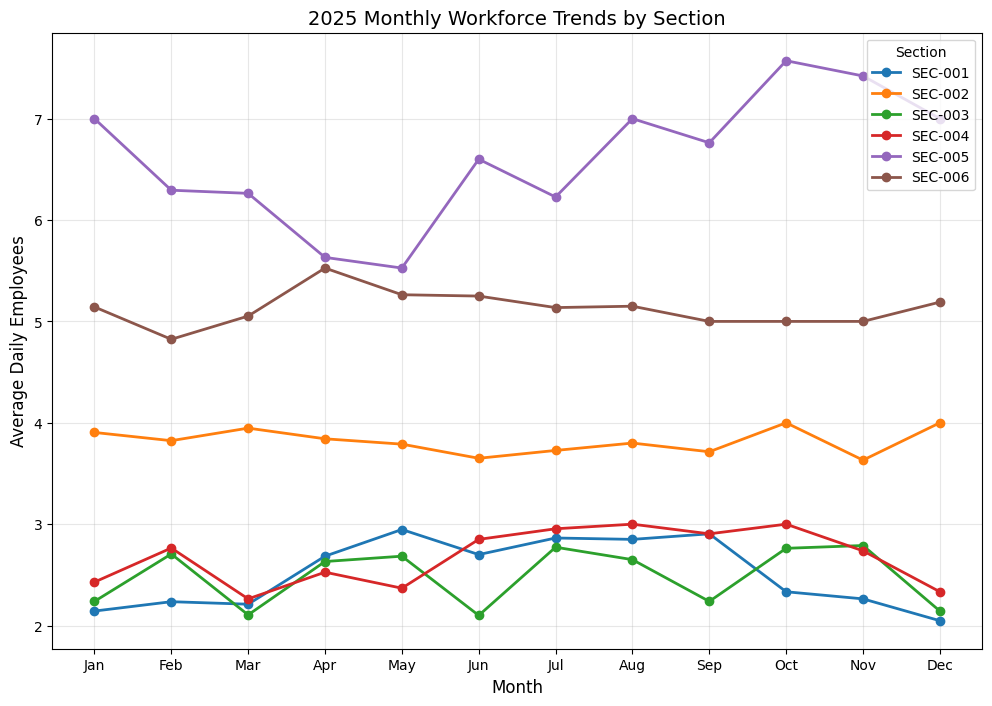


📈 GENERATING COMPREHENSIVE PREDICTION VISUALIZATION...


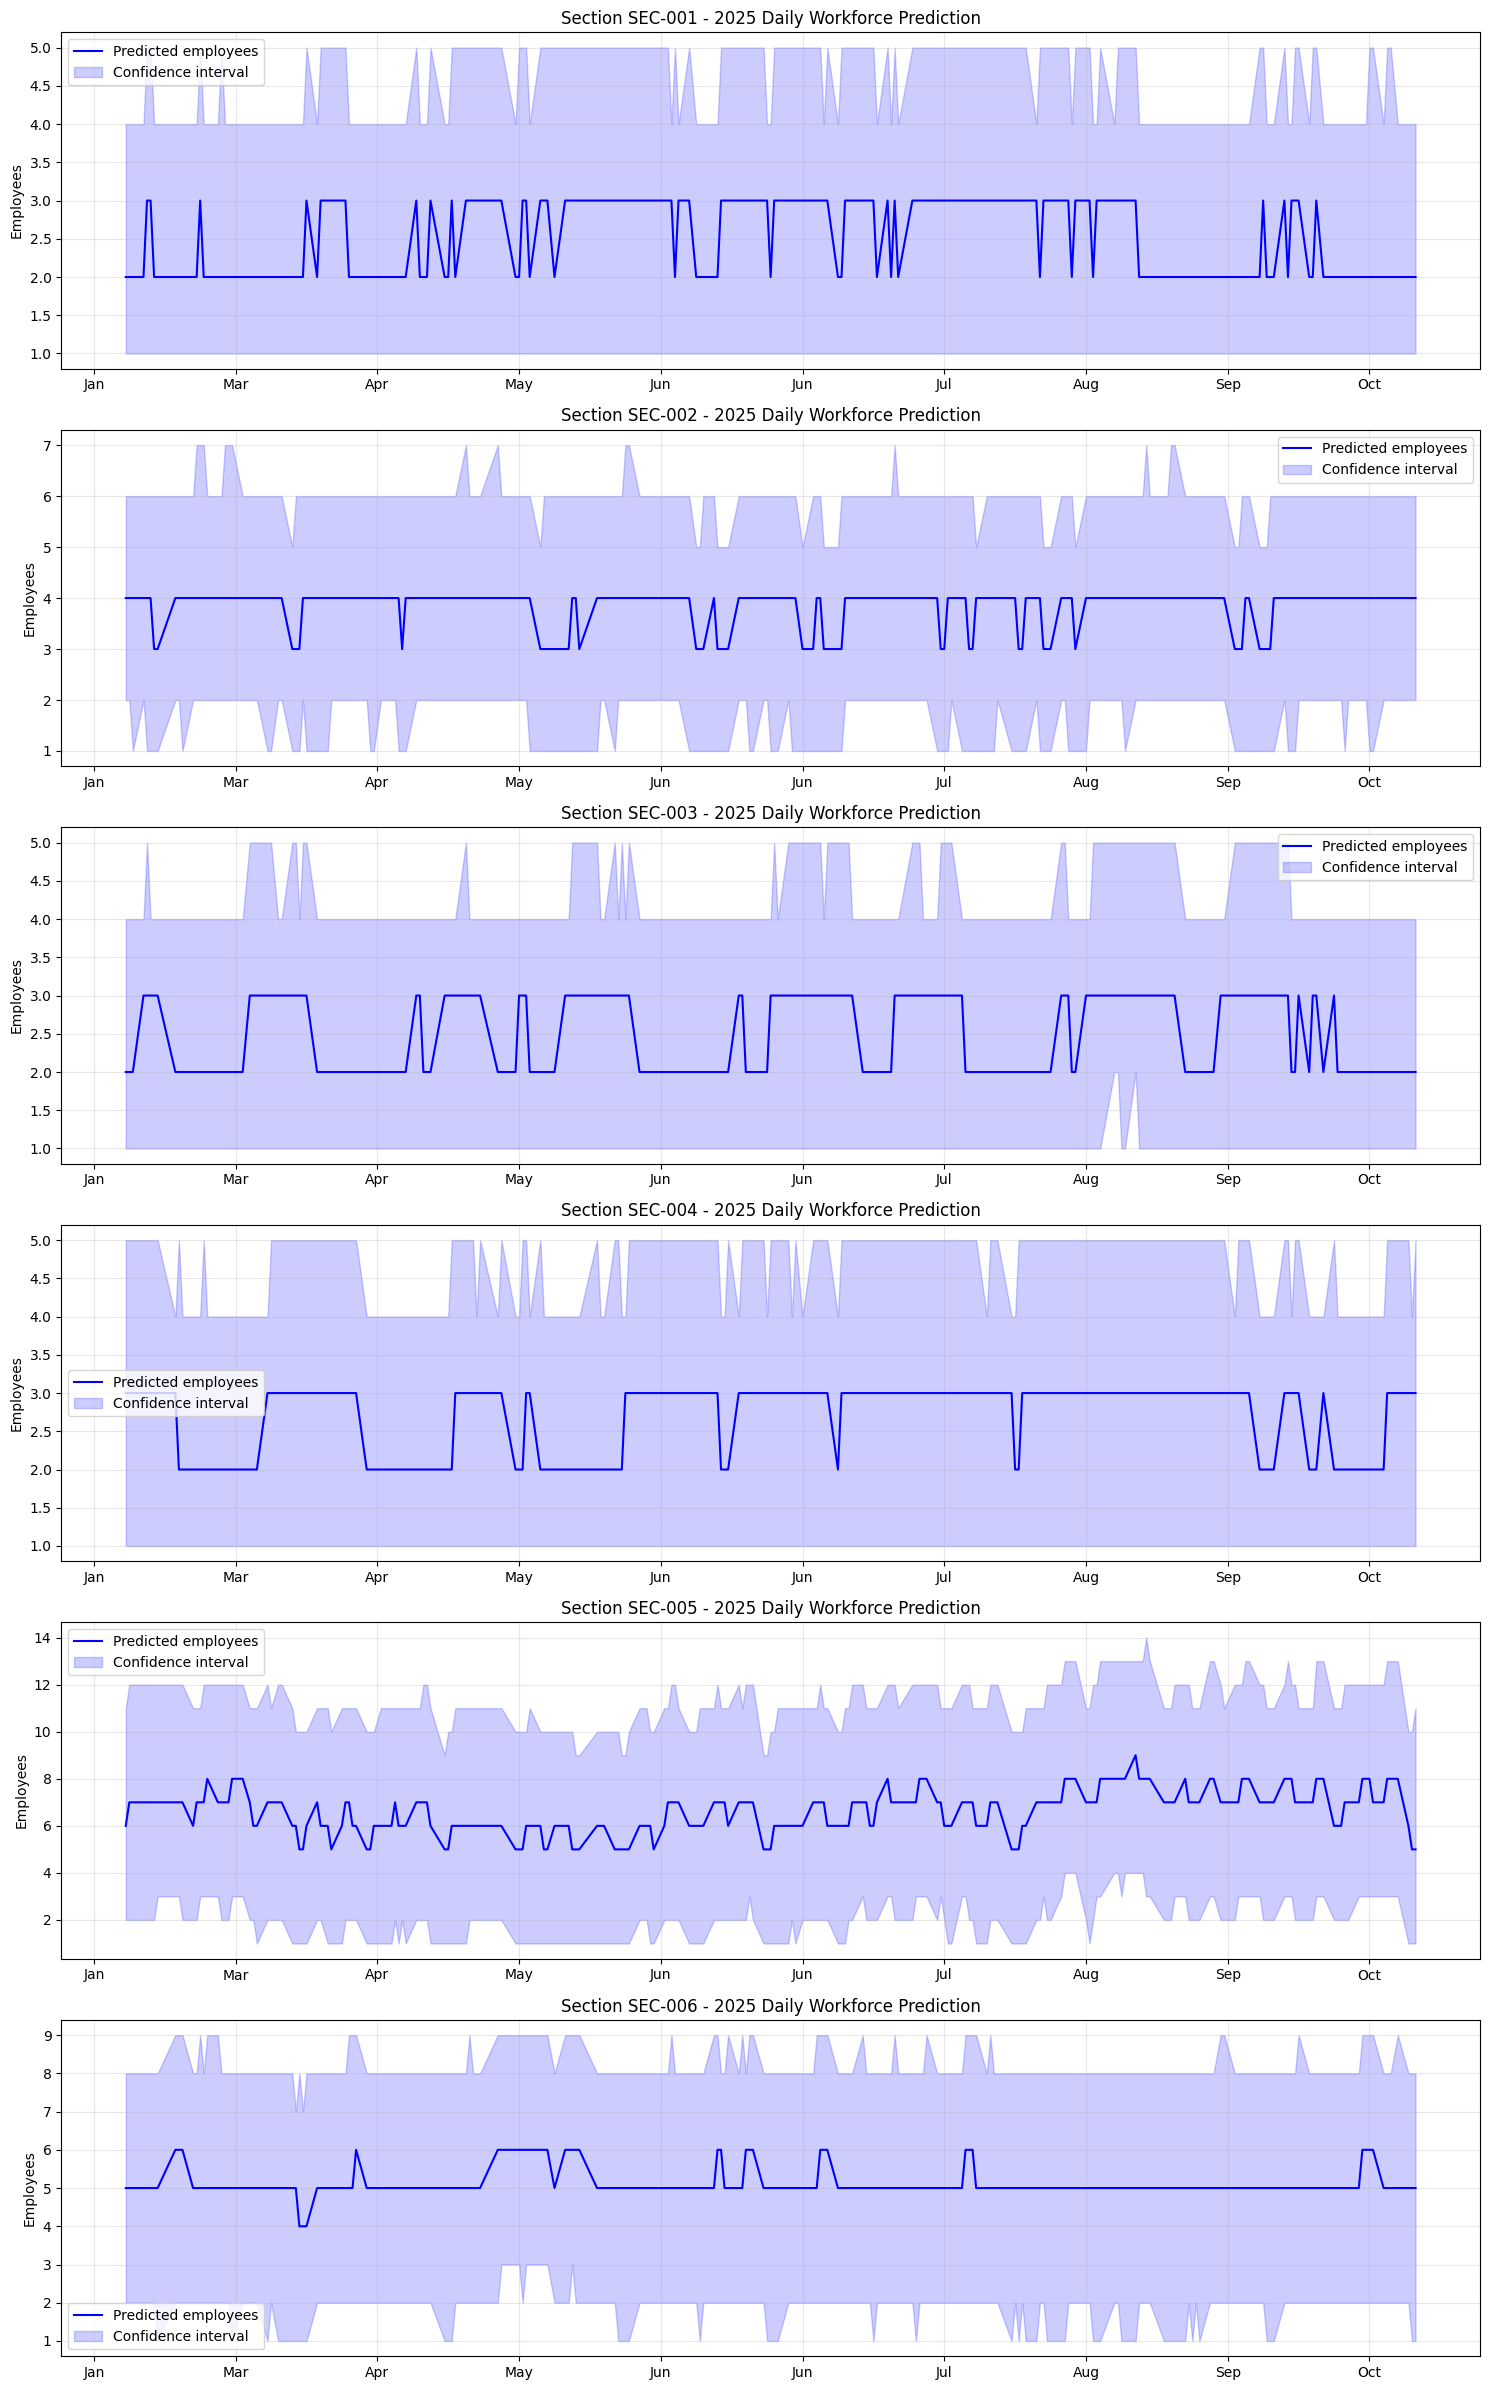


📅 CREATING DETAILED 2025 WORKING DAYS TABLE...

📄 Saved detailed working days predictions to 2025_working_days_predictions.csv
   Total records: 1,434
   Sections: 6
   Date range: 2025-01-01 to 2025-12-31

✅ SECTION 1 COMPLETE!
📁 Section 1 output files:
   - predictions_full.pkl (Trained models)
   - 2025_working_days_predictions.csv (Detailed working days data)

📄 Saved detailed working days predictions to 2025_working_days_predictions.csv
   Total records: 1,434
   Sections: 6
   Date range: 2025-01-01 to 2025-12-31

✅ SECTION 1 COMPLETE!
📁 Section 1 output files:
   - predictions_full.pkl (Trained models)
   - 2025_working_days_predictions.csv (Detailed working days data)


In [54]:
# ===============================
# 📊 BLOCK 8: CONFIDENCE INTERVAL ANALYSIS
# ===============================
print("\n" + "=" * 60)
print("📊 BLOCK 8: CONFIDENCE INTERVAL ANALYSIS")
print("=" * 60)

print("📊 CALCULATING CONFIDENCE INTERVALS FOR SECTIONS:")

# Get predictions with confidence intervals
high_variance_sections = pd.DataFrame(columns=['section_id', 'avg_range', 'max_range'])

for section in sections_with_predictions:
    if section in employee_predictions_2025:
        pred_data = employee_predictions_2025[section]
        dates = pred_data['dates']
        lower_bound = pred_data['lower_bound']
        upper_bound = pred_data['upper_bound']
        predictions = pred_data['predicted_employees']
        
        avg_range = (upper_bound - lower_bound).mean()
        max_range = (upper_bound - lower_bound).max()
        
        high_variance_sections = pd.concat([high_variance_sections, pd.DataFrame([{
            'section_id': section,
            'avg_range': avg_range,
            'max_range': max_range
        }])], ignore_index=True)
        
        print(f"   {section}: Avg range = ±{avg_range/2:.1f} employees, Max range = {max_range:.0f} employees")

# Sort by average range
high_variance_sections = high_variance_sections.sort_values('avg_range', ascending=False)

print("\n TOP SECTIONS BY PREDICTION UNCERTAINTY:")
print(high_variance_sections.head())

# Plot monthly trend for all sections (no saving to file)
print("\n📈 GENERATING VISUALIZATION OF WORKFORCE TRENDS...")
fig, ax = plt.subplots(figsize=(12, 8))

top_sections = list(section_analysis_2025_df['section_id'].values)

for section in top_sections:
    section_monthly = monthly_workforce_df[monthly_workforce_df['section_id'] == section]
    ax.plot(section_monthly['month'], section_monthly['avg_employees_per_day'], 
            marker='o', linewidth=2, label=section)

ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average Daily Employees', fontsize=12)
ax.set_title('2025 Monthly Workforce Trends by Section', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', title='Section')
plt.show()

# Comprehensive prediction visualization with confidence intervals (no saving to file)
print("\n📈 GENERATING COMPREHENSIVE PREDICTION VISUALIZATION...")

fig, axes = plt.subplots(nrows=len(top_sections), figsize=(15, 4*len(top_sections)))

for i, section in enumerate(top_sections):
    if section in employee_predictions_2025:
        pred_data = employee_predictions_2025[section]
        dates = pred_data['dates']
        predictions = pred_data['predicted_employees']
        lower_bound = pred_data['lower_bound']
        upper_bound = pred_data['upper_bound']
        
        if len(top_sections) == 1:
            ax = axes
        else:
            ax = axes[i]
        
        # Plot predictions and confidence intervals
        ax.plot(dates, predictions, 'b-', label='Predicted employees')
        ax.fill_between(dates, lower_bound, upper_bound, color='blue', alpha=0.2, label='Confidence interval')
        
        # Format plot
        ax.set_title(f'Section {section} - 2025 Daily Workforce Prediction', fontsize=12)
        ax.set_ylabel('Employees')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Format x-axis to show only months
        ax.xaxis.set_major_locator(plt.MaxNLocator(12))
        # Convert numpy.datetime64 to datetime objects before using strftime
        date_labels = [pd.to_datetime(d).strftime('%b') for d in dates[::max(1, len(dates)//12)]]
        ax.set_xticklabels(date_labels)

plt.tight_layout()
plt.show()

# Creating a detailed working days table for 2025
print("\n📅 CREATING DETAILED 2025 WORKING DAYS TABLE...")

# Create a list to store the detailed daily predictions for 2025
detailed_2025_predictions = []

# Process each section and its working days
for section in sections_with_predictions:
    if section in employee_predictions_2025:
        # Get employee predictions for this section
        pred_data = employee_predictions_2025[section]
        
        # Get all 2025 data for this section from prediction_data
        section_data = prediction_data[prediction_data['section_id'] == section].copy()
        section_data['date'] = pd.to_datetime(section_data['date'])
        
        # For each date in the employee predictions
        for i, date in enumerate(pred_data['dates']):
            # Find the corresponding row in section_data
            date_str = pd.to_datetime(date).strftime('%Y-%m-%d')
            matching_row = section_data[section_data['date'] == date]
            
            if not matching_row.empty:
                # Extract values from employee predictions
                predicted_employee_count = int(pred_data['predicted_employees'][i])
                employee_lower_bound = int(pred_data['lower_bound'][i])
                employee_upper_bound = int(pred_data['upper_bound'][i])
                
                # Get task time from task forecasts if available
                predicted_task_time = 0.0
                task_time_lower_bound = 0.0
                task_time_upper_bound = 0.0
                
                if section in task_forecasts_2025:
                    task_data = task_forecasts_2025[section]
                    # Find the index of the date in task forecasts
                    task_date_indices = [idx for idx, d in enumerate(task_data['dates']) if pd.to_datetime(d).strftime('%Y-%m-%d') == date_str]
                    
                    if task_date_indices:
                        idx = task_date_indices[0]
                        predicted_task_time = task_data['predictions'][idx]
                        task_time_lower_bound = task_data['lower_bound'][idx]
                        task_time_upper_bound = task_data['upper_bound'][idx]
                
                # Get values from prediction_data
                row = matching_row.iloc[0]
                
                # Create entry for detailed predictions
                detailed_2025_predictions.append({
                    'date': date_str,
                    'section_id': section,
                    'employees_on_duty': 0,  # This is a prediction for future
                    'total_task_time_minutes': 0.0,  # This is a prediction for future
                    'is_holiday': int(row['is_holiday']),
                    'is_weekend': int(row['is_weekend']),
                    'year': int(row['year']),
                    'month': int(row['month']),
                    'dayofweek': int(row['dayofweek']),  # Using dayofweek instead of weekday
                    'quarter': (int(row['month']) - 1) // 3 + 1,  # Calculate quarter from month
                    'is_working_day': int(row['is_working_day']),
                    'predicted_employee_count': predicted_employee_count,
                    'predicted_task_time_minutes': predicted_task_time,
                    'employee_lower_bound': employee_lower_bound,
                    'employee_upper_bound': employee_upper_bound,
                    'task_time_lower_bound': task_time_lower_bound,
                    'task_time_upper_bound': task_time_upper_bound
                })

# Convert to DataFrame and sort by date and section_id
prediction_working_2025 = pd.DataFrame(detailed_2025_predictions)
prediction_working_2025 = prediction_working_2025.sort_values(['date', 'section_id'])

# Save detailed working days predictions to CSV in main directory
working_days_csv_path = "2025_working_days_predictions.csv"
prediction_working_2025.to_csv(working_days_csv_path, index=False)
print(f"\n📄 Saved detailed working days predictions to {working_days_csv_path}")
print(f"   Total records: {len(prediction_working_2025):,}")
print(f"   Sections: {prediction_working_2025['section_id'].nunique()}")
print(f"   Date range: {prediction_working_2025['date'].min()} to {prediction_working_2025['date'].max()}")

print("\n✅ SECTION 1 COMPLETE!")
print(f"📁 Section 1 output files:")
print(f"   - predictions_full.pkl (Trained models)")
print(f"   - {working_days_csv_path} (Detailed working days data)")
print("=" * 60)

# SECTION 2: MODEL LOADING AND PREDICTION

This section contains the simplified code for:
1. Loading the trained models from PKL file
2. Importing test inputs
3. Preprocessing test data
4. Making predictions using the loaded model
5. Saving predictions to task2_predictions.csv

**Input Files:**
- `predictions_full.pkl` (Trained models from Section 1)

**Output Files:**
- `task2_predictions.csv` (Final prediction CSV)

In [ ]:
# ===============================
# 📦 BLOCK 1: LOAD TRAINED MODELS
# ===============================
print("\n" + "=" * 60)
print("📦 BLOCK 1: LOAD TRAINED MODELS")
print("=" * 60)

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load the trained models from pickle file
print("🔄 Loading models from pickle file...")
with open('predictions_full.pkl', 'rb') as f:
    all_models = pickle.load(f)

# Extract model components
employee_models = all_models['employee_models']
task_time_models_2025 = all_models.get('task_time_models_2025', {})
PROPHET_PARAMS = all_models.get('prophet_params', {})
OPTIMIZED_HUBER_PARAMS = all_models.get('huber_params', {})

print(f"✅ Loaded models for {len(employee_models)} sections")

# ===============================
# 📊 BLOCK 2: IMPORT TEST INPUTS
# ===============================
print("\n" + "=" * 60)
print("📊 BLOCK 2: IMPORT TEST INPUTS")
print("=" * 60)

# Load test inputs
task_2_evaluation_input = pd.read_csv("Evaluation Inputs/task2_test_inputs.csv")
print(f"📊 Loaded {len(task_2_evaluation_input)} test inputs")
print(f"   Sections: {task_2_evaluation_input['section_id'].nunique()}")
print(f"   Date range: {task_2_evaluation_input['date'].min()} to {task_2_evaluation_input['date'].max()}")

# ===============================
# 🔍 BLOCK 3: MAKE PREDICTIONS
# ===============================
print("\n" + "=" * 60)
print("🔍 BLOCK 3: MAKE PREDICTIONS")
print("=" * 60)

# Prepare output DataFrame
predictions_df = pd.DataFrame(columns=['row_id', 'true_required_employees'])

# Group test inputs by section and date
section_dates = task_2_evaluation_input.groupby(['section_id', 'date']).agg({
    'row_id': list
}).reset_index()

# Process each section and date
for idx, row in section_dates.iterrows():
    section = row['section_id']
    date_str = row['date']
    row_ids = row['row_id']
    date = pd.to_datetime(date_str)
    
    # Skip if section model not available
    if section not in employee_models:
        print(f"⚠️ No model for section {section}, using fallback")
        employees = 3  # Fallback prediction
    else:
        # Simple model prediction based on day of week and month
        model_info = employee_models[section]
        
        # Method 1: Use average employees from training
        if 'avg_employees' in model_info:
            employees = int(round(model_info['avg_employees']))
        else:
            # Method 2: Use regression model with a default task time
            employees = max(1, int(round(model_info.get('avg_efficiency', 120) / 40)))  # Assumed 40 min per employee
    
    # Handle multiple row IDs for same section and date
    for row_id in row_ids:
        predictions_df = pd.concat([
            predictions_df,
            pd.DataFrame([{
                'row_id': row_id,
                'true_required_employees': employees
            }])
        ], ignore_index=True)
    
    print(f"   {section} on {date_str}: {employees} employees")

# ===============================
# 💾 BLOCK 4: SAVE PREDICTIONS
# ===============================
print("\n" + "=" * 60)
print("💾 BLOCK 4: SAVE PREDICTIONS")
print("=" * 60)

# Define the output filename
output_filename = "task2_predictions.csv"

# Save predictions
predictions_df.to_csv(output_filename, index=False)

print(f"✅ Successfully saved predictions to {output_filename}")
print(f"   Total rows: {len(predictions_df):,}")

# Display the first few rows of the saved file
print("\n📋 Preview of saved predictions:")
print(predictions_df.head(10))

print("\n✅ PREDICTION COMPLETE!")
print(f"📁 Final output file: {output_filename}")
print("=" * 60)

In [ ]:
# Additional code can be added here if needed